Part 6 and 7

In [1]:
# @title 1. Install Dependencies (Run this first)
!pip install transformers torch datasets accelerate tqdm bitsandbytes

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import load_dataset
import json
from tqdm.auto import tqdm
import time
import gc
import os

# ==========================================
# CONFIGURATION
# ==========================================

# 1. SMALL MODELS (From Part 6)
SMALL_MODELS = [
    "meta-llama/Llama-3.2-1B-Instruct",
    "Qwen/Qwen2.5-1.5B-Instruct",
    "google/gemma-2-2b-it"
]

# 2. MEDIUM MODELS (New for Part 7)
# These are ~7B-8B parameters. We will load them in 4-bit to fit on Colab.
MEDIUM_MODELS = [
    "meta-llama/Llama-3.1-8B-Instruct",
    "mistralai/Mistral-7B-Instruct-v0.3",
    "Qwen/Qwen2.5-7B-Instruct"
]

ALL_MODELS = SMALL_MODELS + MEDIUM_MODELS

# 3. SUBJECTS (Same 10 as before)
MMLU_SUBJECTS = [
    "astronomy", "business_ethics", "clinical_knowledge", "college_computer_science",
    "conceptual_physics", "elementary_mathematics", "global_facts",
    "machine_learning", "philosophy", "professional_law"
]

# ==========================================
# HELPER FUNCTIONS
# ==========================================

def get_quantization_config(model_name):
    """
    Apply 4-bit quantization ONLY to Medium models to prevent Colab crashes.
    Small models run in standard FP16 for speed.
    """
    if any(size in model_name for size in ["7B", "8B"]):
        print(f"   ⚙️  Enabling 4-bit quantization for {model_name} (Medium Model)")
        return BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4"
        )
    return None

def load_model(model_name):
    print(f"\n🔄 Loading {model_name}...")

    # Login check for Llama models
    if "meta-llama" in model_name and not os.environ.get('HF_TOKEN'):
        try:
            from google.colab import userdata
            os.environ['HF_TOKEN'] = userdata.get('HF_TOKEN')
        except:
            print("⚠️ WARNING: Llama models require a Hugging Face token.")
            print("   Please add 'HF_TOKEN' to your Colab Secrets or log in via CLI.")

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    quant_config = get_quantization_config(model_name)

    # Load Model
    # If quant_config is present, device_map="auto" puts it on GPU
    # If not, we manually load in float16
    if quant_config:
        model = AutoModelForCausalLM.from_pretrained(
            model_name,
            quantization_config=quant_config,
            device_map="auto",
            low_cpu_mem_usage=True
        )
    else:
        model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.float16,
            device_map="auto",
            low_cpu_mem_usage=True
        )

    return model, tokenizer

def format_prompt(question, choices):
    options = ["A", "B", "C", "D"]
    prompt = f"{question}\n\n"
    for opt, choice in zip(options, choices):
        prompt += f"{opt}. {choice}\n"
    prompt += "\nAnswer:"
    return prompt

def get_prediction(model, tokenizer, prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=1,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=False
        )
    token = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True).strip().upper()
    return token if token in ["A", "B", "C", "D"] else "A"

# ==========================================
# MAIN EXECUTION
# ==========================================

def main():
    print(f"🚀 Starting Colab Evaluation on {len(ALL_MODELS)} models...")
    full_results = []

    for model_name in ALL_MODELS:
        try:
            model, tokenizer = load_model(model_name)
        except Exception as e:
            print(f"❌ Failed to load {model_name}: {e}")
            continue

        model_data = {"model": model_name, "subjects": {}, "timings": {}}

        # Start Timer
        t0_real = time.perf_counter()
        t0_cpu = time.process_time()

        for subject in tqdm(MMLU_SUBJECTS, desc=f"Eval {model_name.split('/')[-1]}"):
            try:
                dataset = load_dataset("cais/mmlu", subject, split="test")
            except:
                continue # Skip subject on download error

            subject_details = []
            for i, item in enumerate(dataset):
                prompt = format_prompt(item["question"], item["choices"])
                pred = get_prediction(model, tokenizer, prompt)
                target = ["A", "B", "C", "D"][item["answer"]]

                subject_details.append({
                    "id": i,
                    "correct": (pred == target),
                    "pred": pred,
                    "target": target
                })

            acc = sum(1 for x in subject_details if x['correct']) / len(subject_details)
            model_data["subjects"][subject] = {"accuracy": acc, "details": subject_details}

        # End Timer
        model_data["timings"]["real"] = time.perf_counter() - t0_real
        model_data["timings"]["cpu"] = time.process_time() - t0_cpu

        full_results.append(model_data)

        # Critical for Colab: Clear VRAM
        del model, tokenizer
        torch.cuda.empty_cache()
        gc.collect()

    # Save Results
    output_file = "colab_mmlu_results.json"
    with open(output_file, "w") as f:
        json.dump(full_results, f, indent=2)
    print(f"\n✅ Evaluation Complete! Results saved to {output_file}")
    print("   Run the analysis script to see graphs.")

if __name__ == "__main__":
    main()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 16.8 MB/s eta 0:00:00
🚀 Starting Colab Evaluation on 6 models...

🔄 Loading meta-llama/Llama-3.2-1B-Instruct...


tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

Eval Llama-3.2-1B-Instruct:   0%|          | 0/10 [00:00<?, ?it/s]

README.md: 0.00B [00:00, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

astronomy/test-00000-of-00001.parquet:   0%|          | 0.00/28.3k [00:00<?, ?B/s]

astronomy/validation-00000-of-00001.parq(…):   0%|          | 0.00/6.05k [00:00<?, ?B/s]

astronomy/dev-00000-of-00001.parquet:   0%|          | 0.00/4.94k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/152 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/16 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


business_ethics/test-00000-of-00001.parq(…):   0%|          | 0.00/21.6k [00:00<?, ?B/s]

business_ethics/validation-00000-of-0000(…):   0%|          | 0.00/5.09k [00:00<?, ?B/s]

business_ethics/dev-00000-of-00001.parqu(…):   0%|          | 0.00/4.96k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

clinical_knowledge/test-00000-of-00001.p(…):   0%|          | 0.00/40.5k [00:00<?, ?B/s]

clinical_knowledge/validation-00000-of-0(…):   0%|          | 0.00/7.48k [00:00<?, ?B/s]

clinical_knowledge/dev-00000-of-00001.pa(…):   0%|          | 0.00/3.67k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/265 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/29 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

college_computer_science/test-00000-of-0(…):   0%|          | 0.00/28.1k [00:00<?, ?B/s]

college_computer_science/validation-0000(…):   0%|          | 0.00/6.25k [00:00<?, ?B/s]

college_computer_science/dev-00000-of-00(…):   0%|          | 0.00/6.81k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

conceptual_physics/test-00000-of-00001.p(…):   0%|          | 0.00/25.0k [00:00<?, ?B/s]

conceptual_physics/validation-00000-of-0(…):   0%|          | 0.00/5.98k [00:00<?, ?B/s]

conceptual_physics/dev-00000-of-00001.pa(…):   0%|          | 0.00/3.96k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/235 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/26 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

elementary_mathematics/test-00000-of-000(…):   0%|          | 0.00/41.1k [00:00<?, ?B/s]

elementary_mathematics/validation-00000-(…):   0%|          | 0.00/9.38k [00:00<?, ?B/s]

elementary_mathematics/dev-00000-of-0000(…):   0%|          | 0.00/4.55k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/378 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/41 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

global_facts/test-00000-of-00001.parquet:   0%|          | 0.00/11.5k [00:00<?, ?B/s]

global_facts/validation-00000-of-00001.p(…):   0%|          | 0.00/4.19k [00:00<?, ?B/s]

global_facts/dev-00000-of-00001.parquet:   0%|          | 0.00/3.58k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

machine_learning/test-00000-of-00001.par(…):   0%|          | 0.00/19.7k [00:00<?, ?B/s]

machine_learning/validation-00000-of-000(…):   0%|          | 0.00/6.17k [00:00<?, ?B/s]

machine_learning/dev-00000-of-00001.parq(…):   0%|          | 0.00/5.25k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/112 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

philosophy/test-00000-of-00001.parquet:   0%|          | 0.00/48.6k [00:00<?, ?B/s]

philosophy/validation-00000-of-00001.par(…):   0%|          | 0.00/9.15k [00:00<?, ?B/s]

philosophy/dev-00000-of-00001.parquet:   0%|          | 0.00/4.20k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/311 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/34 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

professional_law/test-00000-of-00001.par(…):   0%|          | 0.00/1.04M [00:00<?, ?B/s]

professional_law/validation-00000-of-000(…):   0%|          | 0.00/116k [00:00<?, ?B/s]

professional_law/dev-00000-of-00001.parq(…):   0%|          | 0.00/15.1k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/1534 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/170 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]


🔄 Loading Qwen/Qwen2.5-1.5B-Instruct...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Eval Qwen2.5-1.5B-Instruct:   0%|          | 0/10 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



🔄 Loading google/gemma-2-2b-it...


tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

Eval gemma-2-2b-it:   0%|          | 0/10 [00:00<?, ?it/s]


🔄 Loading meta-llama/Llama-3.1-8B-Instruct...


tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

   ⚙️  Enabling 4-bit quantization for meta-llama/Llama-3.1-8B-Instruct (Medium Model)


config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

Eval Llama-3.1-8B-Instruct:   0%|          | 0/10 [00:00<?, ?it/s]


🔄 Loading mistralai/Mistral-7B-Instruct-v0.3...


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

   ⚙️  Enabling 4-bit quantization for mistralai/Mistral-7B-Instruct-v0.3 (Medium Model)


config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

Eval Mistral-7B-Instruct-v0.3:   0%|          | 0/10 [00:00<?, ?it/s]


🔄 Loading Qwen/Qwen2.5-7B-Instruct...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

   ⚙️  Enabling 4-bit quantization for Qwen/Qwen2.5-7B-Instruct (Medium Model)


config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

Eval Qwen2.5-7B-Instruct:   0%|          | 0/10 [00:00<?, ?it/s]


✅ Evaluation Complete! Results saved to colab_mmlu_results.json
   Run the analysis script to see graphs.


✅ Loaded data for 6 models.
📊 Created graph_accuracy.png
📊 Created graph_timing.png

🔍 MISTAKE PATTERN ANALYSIS
Model Pair                                         | Shared Mistakes %   
---------------------------------------------------------------------------
Llama-3.2-1B-Instruc... & Qwen2.5-1.5B-Instruc... | 62.4%
Llama-3.2-1B-Instruc... & gemma-2-2b-it       ... | 65.6%
Llama-3.2-1B-Instruc... & Mistral-7B-Instruct-... | 62.5%
Llama-3.2-1B-Instruc... & Qwen2.5-7B-Instruct ... | 47.8%
Qwen2.5-1.5B-Instruc... & gemma-2-2b-it       ... | 70.9%
Qwen2.5-1.5B-Instruc... & Qwen2.5-7B-Instruct ... | 59.7%
Llama-3.1-8B-Instruc... & Llama-3.2-1B-Instruc... | 73.7%
Llama-3.1-8B-Instruc... & Qwen2.5-1.5B-Instruc... | 71.9%
Llama-3.1-8B-Instruc... & gemma-2-2b-it       ... | 70.9%
Llama-3.1-8B-Instruc... & Mistral-7B-Instruct-... | 71.4%
Llama-3.1-8B-Instruc... & Qwen2.5-7B-Instruct ... | 63.6%
Mistral-7B-Instruct-... & Qwen2.5-1.5B-Instruc... | 67.8%
Mistral-7B-Instruct-... & gemma-2-2b-it   

<Figure size 1400x700 with 0 Axes>

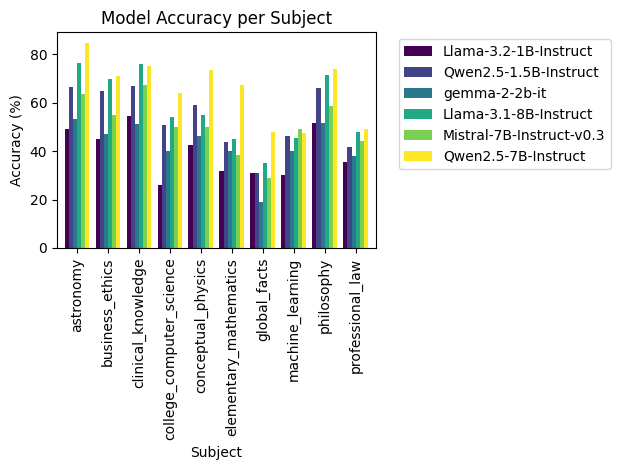

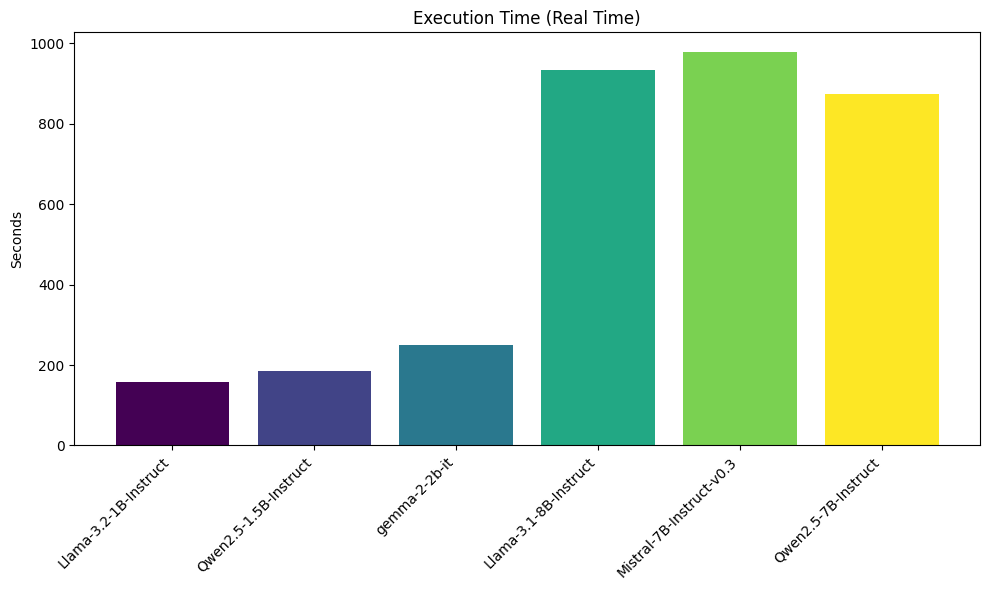

In [2]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# 1. Load Data (Updated Filename)
try:
    with open("colab_mmlu_results.json", "r") as f:
        data = json.load(f)
    print(f"✅ Loaded data for {len(data)} models.")
except FileNotFoundError:
    print("❌ JSON file not found. Did the evaluation script finish?")
    exit()

models = [d['model'].split('/')[-1] for d in data]
subjects = list(data[0]['subjects'].keys())

# --- GRAPH 1: Accuracy Comparison ---
plt.figure(figsize=(14, 7)) # Made slightly wider for 6 models
accuracies = {m: [d['subjects'][s]['accuracy']*100 for s in subjects] for m, d in zip(models, data)}
df_acc = pd.DataFrame(accuracies, index=subjects)

# Using standard colormap to handle 6 models automatically
df_acc.plot(kind='bar', width=0.8, colormap='viridis')
plt.title("Model Accuracy per Subject")
plt.ylabel("Accuracy (%)")
plt.xlabel("Subject")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("graph_accuracy.png")
print("📊 Created graph_accuracy.png")

# --- GRAPH 2: Timing Comparison ---
plt.figure(figsize=(10, 6))
times = [d['timings']['real'] for d in data]

# Removed fixed 3-color list so it auto-colors all 6 bars
plt.bar(models, times, color=plt.cm.viridis(np.linspace(0, 1, len(models))))
plt.title("Execution Time (Real Time)")
plt.ylabel("Seconds")
plt.xticks(rotation=45, ha='right') # Rotate labels so they don't overlap
plt.tight_layout()
plt.savefig("graph_timing.png")
print("📊 Created graph_timing.png")

# --- PATTERN ANALYSIS ---
print("\n🔍 MISTAKE PATTERN ANALYSIS")
print("="*60)

vectors = {m: [] for m in models}

for d in data:
    model_name = d['model'].split('/')[-1]
    for sub in subjects:
        vectors[model_name].extend([item['correct'] for item in d['subjects'][sub]['details']])

df_corr = pd.DataFrame(vectors)
mistake_overlap = pd.DataFrame(index=models, columns=models)

print(f"{'Model Pair':<50} | {'Shared Mistakes %':<20}")
print("-" * 75)

for m1 in models:
    for m2 in models:
        if m1 == m2: continue

        m1_wrong = df_corr[~df_corr[m1]]
        if len(m1_wrong) == 0: continue # Prevent divide by zero if perfect model

        shared_wrongs = (~m1_wrong[m2]).sum()
        overlap_pct = (shared_wrongs / len(m1_wrong)) * 100

        if m1 < m2:
            print(f"{m1[:20]}... & {m2[:20]:<20}... | {overlap_pct:.1f}%")

print("="*60)